# Introduction

In this study, we are going to test the possibility of enabling drones to detect wind direction using stabilizer data. We switch to stabilizer instead of previously used gyroscope and accelerometer data is because stabilizer does not re-estabilish its reference point, and it is measured in degrees. We follow the same feature engineering procedure as in the previous studies. To help us understand the data better, we visualize the data in both frequency and time domains.

# 1. Load Data

In [1]:
from utils.data_loading_utils import *
from transformers.featureGenerator import FeatureGenerator
from utils.metrics_utils import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
cols = ["stabilizer.roll", "stabilizer.pitch", "stabilizer.yaw"]

### No Wind Data

In [3]:
no_wind = load_data(0, 10, 'drone1')[cols]
no_wind_transformer = FeatureGenerator(1, 'stabilizer', False, 0)
no_wind_transformer.fit(no_wind, 1)
no_wind_transformed = no_wind_transformer.transform(no_wind)

In [4]:
no_wind_transformed['label'] = [0 for x in range(no_wind_transformed.shape[0])]

### Train/Test Split - 8:2

In [5]:
no_wind_size = no_wind_transformed.shape[0]
no_wind_train = no_wind_transformed.iloc[:int(no_wind_size*0.8), :]
no_wind_test = no_wind_transformed.iloc[int(no_wind_size*0.8):, :]

### Front Wind Data

In [6]:
front = load_data(1, 10, 'drone1')[cols]
front_transformer = FeatureGenerator(1, 'stabilizer', False, 0)
front_transformer.fit(front, 1)
front_transformed = front_transformer.transform(front)

In [7]:
front_transformed['label'] = [1 for x in range(front_transformed.shape[0])]

### Train/Test Split - 8:2

In [8]:
front_wind_size = front_transformed.shape[0]
front_wind_train = front_transformed.iloc[:int(front_wind_size*0.8), :]
front_wind_test = front_transformed.iloc[int(front_wind_size*0.8):, :]

### Back Wind Data

In [9]:
back = load_data(2, 10, 'drone1')[cols]
back_transformer = FeatureGenerator(1, 'stabilizer', False, 0)
back_transformer.fit(back, 1)
back_transformed = back_transformer.transform(back)

In [10]:
back_transformed['label'] = [2 for x in range(back_transformed.shape[0])]

### Train/Test Split - 8:2

In [11]:
back_wind_size = back_transformed.shape[0]
back_wind_train = back_transformed.iloc[:int(back_wind_size*0.8), :]
back_wind_test = back_transformed.iloc[int(back_wind_size*0.8):, :]

### Left Wind Data

In [12]:
left = load_data(3, 10, 'drone1')[cols]
left_transformer = FeatureGenerator(1, 'stabilizer', False, 0)
left_transformer.fit(left, 1)
left_transformed = back_transformer.transform(left)

In [13]:
left_transformed['label'] = [3 for x in range(left_transformed.shape[0])]

### Train/Test Split - 8:2

In [14]:
left_wind_size = left_transformed.shape[0]
left_wind_train = left_transformed.iloc[:int(left_wind_size*0.8), :]
left_wind_test = left_transformed.iloc[int(left_wind_size*0.8):, :]

### Right Wind Data

In [15]:
right = load_data(4, 10, 'drone1')[cols]
right_transformer = FeatureGenerator(1, 'stabilizer', False, 0)
right_transformer.fit(right, 1)
right_transformed = right_transformer.transform(right)

In [16]:
right_transformed['label'] = [4 for x in range(right_transformed.shape[0])]

### Train/Test Split - 8:2

In [17]:
right_wind_size = right_transformed.shape[0]
right_wind_train = right_transformed.iloc[:int(right_wind_size*0.8), :]
right_wind_test = right_transformed.iloc[int(right_wind_size*0.8):, :]

In [18]:
no_wind_temp = no_wind_transformed
no_wind_temp['label'] = ['no wind' for x in range(no_wind_temp.shape[0])]

In [19]:
front_wind_temp = front_transformed
front_wind_temp['label'] = ['front wind' for x in range(front_wind_temp.shape[0])]

In [20]:
back_wind_temp = back_transformed
back_wind_temp['label'] = ['back wind' for x in range(back_wind_temp.shape[0])]

In [21]:
right_temp = right_transformed
right_temp['label'] = ['right wind' for x in range(right_temp.shape[0])]

In [22]:
left_temp = left_transformed
left_temp['label'] = ['left wind' for x in range(left_temp.shape[0])]

In [23]:
combined_train = no_wind_train.append(front_wind_train, ignore_index=True)
combined_train = combined_train.append(back_wind_train, ignore_index=True)
combined_train = combined_train.append(right_wind_train, ignore_index=True)
combined_train = combined_train.append(left_wind_train, ignore_index=True)

In [24]:
X_train = combined_train.iloc[:, :-1]
y_train = combined_train.iloc[:, -1]

# 2. Classification

In [25]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [26]:
combined_test = no_wind_test.append(front_wind_test)
combined_test = combined_test.append(back_wind_test)
combined_test = combined_test.append(right_wind_test)
combined_test = combined_test.append(left_wind_test)

In [27]:
X_test = combined_test.iloc[:, :-1]
y_test = combined_test.iloc[:, -1]

In [28]:
y_pred = clf.predict(X_test)

The overall accuracy is not as good as we expected to see. We were hoping to see at least 90% of accuracy becuase the drone has to react to the change of environment (wind) as accuractly and quickly as possible. 62% of accuracy is not satisfactory at all. 

In [29]:
print('The overall accuracy is {:.3f}'.format(clf.score(X_test, y_test)))

The overall accuracy is 0.624


If we look at the numbers on the diagonal line of the confusion matrix, we can see that the classifier got majority of the data points correctly predicted. However, if we look at the confusion matrix as a whole, we can see mis-classifications all over the place. The unsatisfactory result raised two questions:
    1. Why did the classifier performed so poorly?
    2. Since we still have 62% of the points correctly predicted, what exactly was the classifier classifying?
To answer these two questions, we first visualize the raw data in time domian.

In [30]:
get_confusion_matrix(y_test, y_pred)

,actual_0,actual_1,actual_2,actual_3,actual_4
predicted_0,3143,168,378,22,58
predicted_1,240,2311,505,361,364
predicted_2,36,602,1553,932,633
predicted_3,9,520,146,2078,1003
predicted_4,76,91,149,799,2666


In [33]:
from scipy import signal

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 6))
sns.set(color_codes=True)

<Figure size 1152x432 with 0 Axes>

In [31]:
no_wind_sample = no_wind.iloc[1000:1700, :]
front_wind_sample = front.iloc[1000:1700, :]
back_wind_sample = back.iloc[1000:1700, :]
left_wind_sample = left.iloc[1000:1700, :]
right_wind_sample = right.iloc[1000:1700, :]

# 4. Visualization in Time-Domain

The graph below is the visualization for roll data. There are two things that we instantly noticed.

First, the data look somewhat symmetric in all cases. Once the line shoots up to a positive number, it immediately drops and passes 0 and get to a similiar negative number. This is probably due to the drone was constantly adjusting its position during a flight. There is no prominant factor that helps the classifier to distinguish one class from the rest. Roll data is the drone rotating along the direction where its front is pointing at. In theory, right wind and left wind data should have a prominant difference in the roll data. For example, we hoped to see the left wind data leaning more towards the positive side, while the right wind data would lean more towards the negative side, namely, a negative similiarity. However, in the picture, they all occilate around x-axis. 

Second, the ranges or the amplitude in which the lines are fluctuating are different. 

In conclusion, the answer to the first question is that there is no obvious trend can be used to tell the difference between classes. The answer to the second question is that the classifying the amplitudes of the data instead a trend in the data.

To validate our two reasons, we calculated time-series data similiarity and visualized data in frequency-domain.

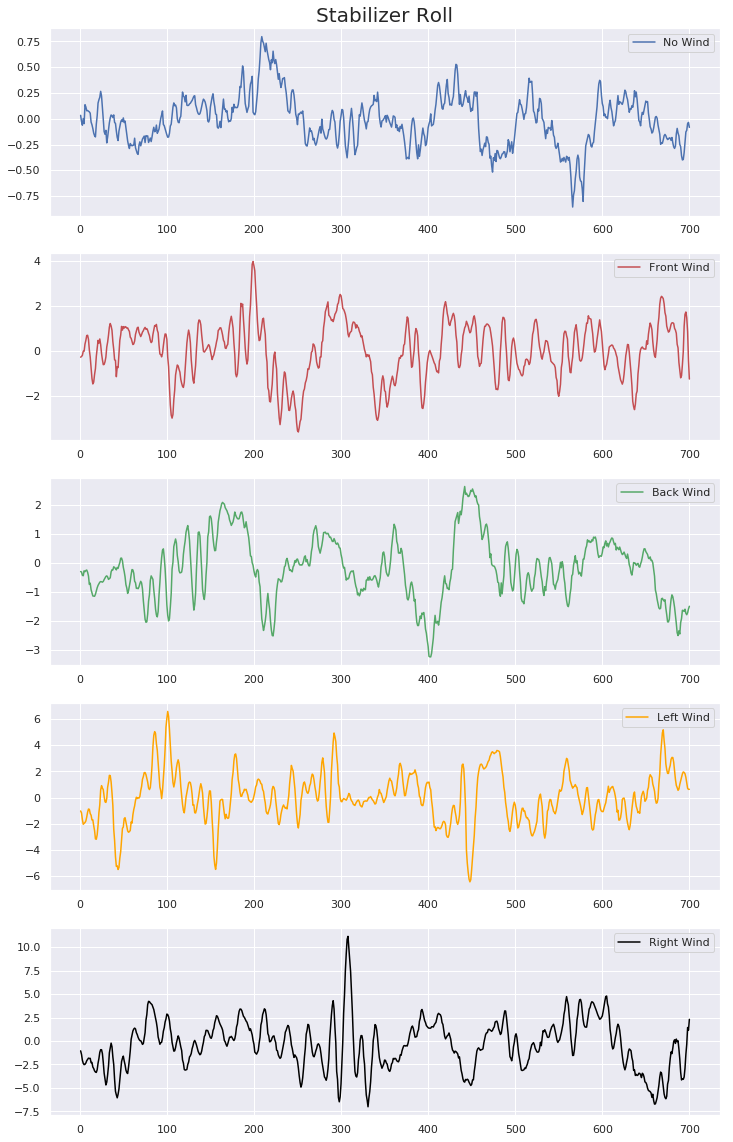

In [35]:
fig = plt.figure(figsize=(12, 20))

ax1_no_wind = fig.add_subplot(5, 1, 1)
ax1_no_wind.set_title('Stabilizer Roll', fontsize=20)
ax1_no_wind.plot([x for x in range(1, 701)], no_wind_sample["stabilizer.roll"])
ax1_no_wind.legend(['No Wind'])

ax2_front_wind = fig.add_subplot(5, 1, 2)
ax2_front_wind.plot([x for x in range(1, 701)], front_wind_sample["stabilizer.roll"], color='r')
ax2_front_wind.legend(['Front Wind'])

ax3_back_wind = fig.add_subplot(5, 1, 3)
ax3_back_wind.plot([x for x in range(1, 701)], back_wind_sample["stabilizer.roll"], color='g')
ax3_back_wind.legend(['Back Wind'])

ax4_left_wind = fig.add_subplot(5, 1, 4)
ax4_left_wind.plot([x for x in range(1, 701)], left_wind_sample["stabilizer.roll"], color='orange')
ax4_left_wind.legend(['Left Wind'])

ax5_right_wind = fig.add_subplot(5, 1, 5)
ax5_right_wind.plot([x for x in range(1, 701)], right_wind_sample["stabilizer.roll"], color='black')
_ = ax5_right_wind.legend(['Right Wind'])

# 3.Compute Similiarity between Time-series Data 

There are several ways to calculate the similiarity (correlation) between a pair of time-series data:
    1. Euclidean distance
    2. Dynamic Time Warping
    3. Cross Correlation
The problem with the first two methods is that we do not have a benchmark to compare our value to, which makes interpret corrleation scores almost impossible in our case. Thus, we went with the nomalized version of cross correlation. The nomalized cross correlation produces values between -1 and 1. -1 indicates a strong negative similiarity, and 1 suggests a prominant positive correlation between a pair of time-series data. Another positive side of cross correlation is that it is mostly used in measuring the similiarity between a pair of signal data, which is the exact type of stabilizer data.

Now, let's take a look at the correlation score table below.

In [50]:
def norm_corr(signal1, signal2):
    numerator = np.sum((signal1-np.mean(signal1))*(signal2-np.mean(signal2)))
    denominator = np.sqrt(np.sum(np.power(signal1-np.mean(signal1), 2))*np.sum(np.power(signal2-np.mean(signal2), 2)))
    
    return numerator/denominator

In [51]:
corr_roll = pd.DataFrame(data=[], 
                         columns=['no wind', 'front wind', 'back wind', 'left wind', 'right wind'],
                        index=['no wind', 'front wind', 'back wind', 'left wind', 'right wind'])
corr_pitch = pd.DataFrame(data=[], 
                         columns=['no wind', 'front wind', 'back wind', 'left wind', 'right wind'],
                        index=['no wind', 'front wind', 'back wind', 'left wind', 'right wind'])

In [52]:
for i, data1 in zip([0, 1, 2 ,3 ,4], [no_wind, front, back, left, right]):
    temp_roll = []
    temp_pitch = []
    for data2 in [no_wind, front, back, left, right]:
        temp_roll.append(norm_corr(data1['stabilizer.roll'], data2['stabilizer.roll']))
        temp_pitch.append(norm_corr(data1['stabilizer.pitch'], data2['stabilizer.pitch']))
    corr_roll.iloc[i, :] = temp_roll
    corr_pitch.iloc[i, :] = temp_pitch

The following is the correlation score table. We can instantly see that the values are all pretty close to 0, which means the data bear no resemblance at all, which confirmed our first answer that there is no prominant factor that helps the model to tell the difference between one class and the rest.

In [53]:
corr_roll

,no wind,front wind,back wind,left wind,right wind
no wind,1,0.089263,0.015151,-0.00990466,0.0979307
front wind,0.089263,1,0.0426228,0.0255829,0.0397327
back wind,0.015151,0.0426228,1,-0.0298946,-0.0319134
left wind,-0.00990466,0.0255829,-0.0298946,1,-0.0822527
right wind,0.0979307,0.0397327,-0.0319134,-0.0822527,1


# 4. Visualization in Frequency-Domain

In this section, we are going to show visualiztion of all data in frequency domian. In this visualization, we used a plot called power spectral density, whose y-axis is power density (power/Hz), and the x-axis is frequency. To calculate power density, we used Fourier Transform to get the Fourier coefficients, which is equivalent to decomposing the signal data into sine and cosin components. And we use each coefficient to calculate the amplitude of each component, then use the amplitudes to compute all the power density. 

In [36]:
def plot_in_frequency_domain(data, label, sensor, color):
    x = data[sensor+'.roll']
    y = data[sensor+'.pitch']
    z = data[sensor+'.yaw']
    f = plt.figure(figsize=(15, 3))
    ax = f.add_subplot(131)
    ax2 = f.add_subplot(132)
    ax3 = f.add_subplot(133)
    
    x_fft = np.fft.fft(x)
    f_x = np.fft.fftfreq(x.shape[0])
    Pxx_den_x = (x_fft*np.conj(x_fft))/x_fft.shape[0]
    ax.set_title(sensor + ': roll axis, label: ' + str(label))
    ax.plot(f_x, Pxx_den_x, color=color)
    
    y_fft = np.fft.fft(y)
    f_y = np.fft.fftfreq(y.shape[0])
    Pxx_den_y = (y_fft*np.conj(y_fft))/y_fft.shape[0]
    ax2.set_title(sensor + ': pitch axis, label: ' + str(label))
    ax2.plot(f_y, Pxx_den_y, color=color)
    
    z_fft = np.fft.fft(z)
    f_z = np.fft.fftfreq(z.shape[0])
    Pxx_den_z = (z_fft*np.conj(z_fft))/z_fft.shape[0]
    ax3.set_title(sensor + ': yaw axis, label: ' + str(label))
    ax3.plot(f_z, Pxx_den_z, color=color)

Let's look at the visualization for each roll, pitch and yaw one by one.

Roll:
Roll data, as mentioned before, is primarily responsbile for measuring the changes in degrees when the drone is rotating to the left and the right. The left wind and right wind do have a higher power density. 

Pitch:
They all peaked at similiar power density except the back wind data. The reason being, the drone was set to fly at a constant speed. While it is flying away from the wind, it is actually getting push by the wind. To maintain a contant speed, the drone do not have to tilt forward as much as it is flying towards wind or in no wind condition. The front wind peaks at a larger power density than the rest. The reason is the opposite of the bakc wind. It has to tilt more to fight agains the resistance produced by the front wind.

Yaw:
This data is quite random. However, this axis reacts to the side wind the most because side wind could cause the wind to rotate alone the vertical axis. 

Although the data peak at different power density, the problem is not at the higher end. Rather, the problem lies in the lower end. The data points in the lower end of the power spectral density plot all have similiar power density, which is calculated by amplitudes * amplitudes / frequency. Thus, the classifier could not tell the difference between these points with similiar power density (amplitude). This shows that the classifier was classifying the amplitude of the data, which confirmed our second answer.

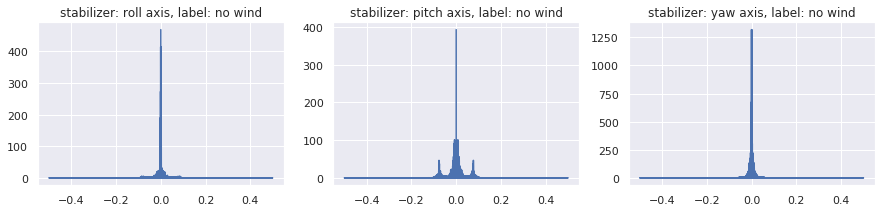

In [37]:
plot_in_frequency_domain(no_wind, 'no wind', 'stabilizer', 'b')

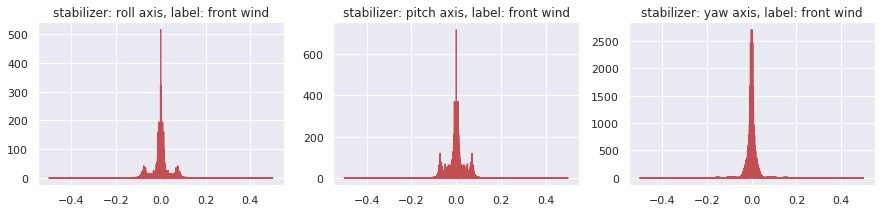

In [38]:
plot_in_frequency_domain(front, 'front wind', 'stabilizer', 'r')

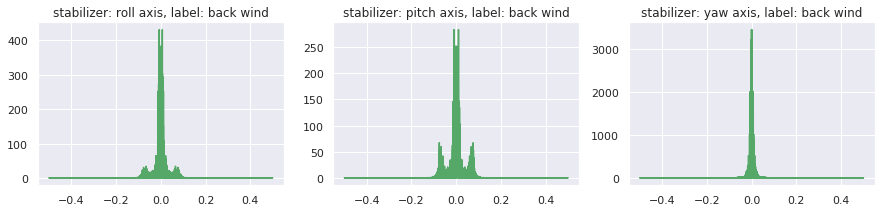

In [39]:
plot_in_frequency_domain(back, 'back wind', 'stabilizer', 'g')

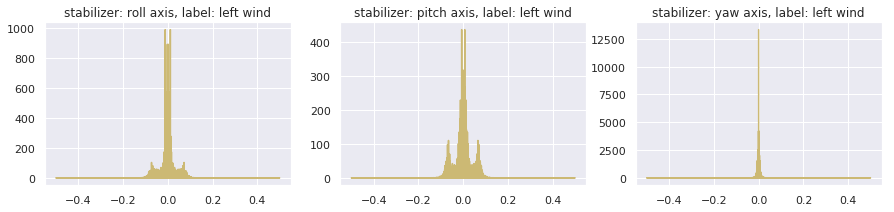

In [40]:
plot_in_frequency_domain(left, 'left wind', 'stabilizer', 'y')

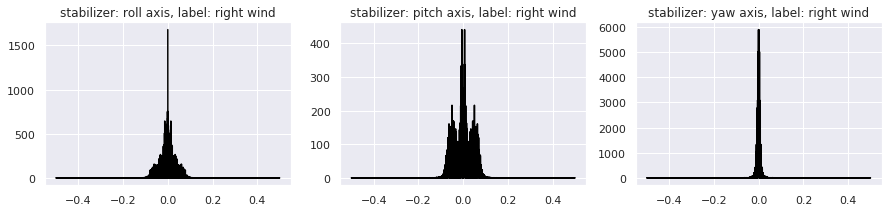

In [41]:
plot_in_frequency_domain(right, 'right wind', 'stabilizer', 'black')